In [57]:
import pandas as pd
import numpy as np
import pickle
import wfdb
import ast
import pywt
from resnet50 import *
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn

path_pkl = "C:/Users/vedag/OneDrive/Desktop/Project/a_ptb_xl/jupyter_notebooks/pkl_files/"
path = "C:/Users/vedag/OneDrive/Desktop/Project/a_ptb_xl/jupyter_notebooks/data/"

In [28]:
database = pd.read_csv(path + "ptbxl_database.csv", index_col = 'ecg_id')

In [29]:
database.drop(axis=1, columns=['height', 'weight', 'infarction_stadium1', 'infarction_stadium2', 'electrodes_problems', 'pacemaker', 'validated_by'], inplace=True)

In [30]:
sampling_rate = 500

In [31]:
database.scp_codes = database.scp_codes.apply(lambda x: ast.literal_eval(x))

In [32]:
scp_df = pd.read_csv(path+'scp_statements.csv', index_col=0)

In [36]:
scp_df.drop(axis=1, columns=['rhythm', 'form', 'aECG REFID', 'DICOM Code', 'CDISC Code'], inplace=True)

In [37]:
scp_df = scp_df[scp_df.diagnostic == 1]

In [38]:
def aggregate_diagnostic(y_dic):
    temp = []
    for key in y_dic.keys():
        if key in scp_df.index:
            temp.append(scp_df.loc[key].diagnostic_class)
    return list(set(temp))

# Apply diagnostic superclass
"""
If the dict keys in database.scp_codes are available in agg_diff index, put them in diagnostic_superclass
 - This means scp_statements.csv contains diagnostic class in the first column
"""
database['diagnostic_superclass'] = database.scp_codes.apply(aggregate_diagnostic)

In [39]:
database['diagnostic_superclass_len'] = database['diagnostic_superclass'].apply(len)

In [40]:
print('Number of records with 4 labels : {0}\nNumber of records with 3 labels : {1}\nNumber of records with 2 labels : {2}\nNumber of records with 1 label : {3}'.format(len(database[database.diagnostic_superclass_len == 4]), len(database[database.diagnostic_superclass_len == 3]), len(database[database.diagnostic_superclass_len == 2]), len(database[database.diagnostic_superclass_len == 1])))

Number of records with 4 labels : 159
Number of records with 3 labels : 920
Number of records with 2 labels : 4079
Number of records with 1 label : 16272


In [41]:
database = database[database.diagnostic_superclass_len == 1].reset_index(drop=True)

In [43]:
# classes -- 0 = normal, 1= MI, 2 = STTC, 3=HYP, 4=CD
def classes(k):
    if k == ['MI']:
        return 1
    elif k == ['STTC']:
        return 2
    elif k == ['HYP']:
        return 3
    elif k == ['CD']:
        return 4
    else:
        return 0
database["class"] = database.diagnostic_superclass.apply(classes)

In [47]:
database = database[(database["class"]==0) | (database["class"] == 1)]

In [48]:
database.reset_index(inplace= True)
database.to_pickle("database_with_baseline_drift_and_noise_cols_(norm & mi).pkl")

In [65]:
print(len(database["baseline_drift"]))
database.head()

11621


,level_0,index,patient_id,age,sex,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,strat_fold,filename_lr,filename_hr,diagnostic_superclass,diagnostic_superclass_len,class
0,0,0,15709.0,56.0,1,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM],1,0
1,1,1,13243.0,19.0,0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM],1,0
2,2,2,20372.0,37.0,1,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM],1,0
3,3,3,17014.0,24.0,0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM],1,0
4,4,4,17448.0,19.0,1,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM],1,0


In [70]:
df_with_blw_file_class = database[['baseline_drift', 'filename_hr', 'class']]

In [74]:
df_with_blw_file_class["class"].unique()

array([0, 1], dtype=int64)

In [75]:
df_with_blw_file_class.to_pickle(path_pkl + "df_with_blw_file_class_(all norm & mi).pkl")

In [77]:
df = df_with_blw_file_class

In [78]:
normal_dataframe = df[df["class"] == 0]
mi_dataframe = df[df["class"] == 1]

In [79]:
def load_raw_data(df, sampling_rate, path):
    # Loading all data with signal and meta information
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
     
    # Eliminating meta information. We are selecting only signal value of 12 leads 
    data = np.array([signal for signal, meta in data])
    return data


# Load raw signals for both normal and mi data
normal = load_raw_data(normal_dataframe, sampling_rate, path)
mi = load_raw_data(mi_dataframe, sampling_rate, path)

,baseline_drift,filename_hr,class
0,NaN,records500/00000/00001_hr,0
1,NaN,records500/00000/00002_hr,0
2,NaN,records500/00000/00003_hr,0
3,", II,III,AVF",records500/00000/00004_hr,0
4,", III,AVR,AVF",records500/00000/00005_hr,0
...,...,...,...
11616,NaN,records500/21000/21830_hr,0
11617,NaN,records500/21000/21831_hr,0
11618,NaN,records500/21000/21834_hr,0
11619,NaN,records500/21000/21836_hr,0


In [103]:
normal_dataframe.reset_index(inplace = True)
mi_dataframe.reset_index(inplace = True)

In [107]:
normal_dataframe.drop(["index"], axis = 1,inplace = True)
mi_dataframe.drop(["index"], axis = 1,inplace = True)

C:\Users\vedag\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [110]:
mi_dataframe.to_pickle(path_pkl + "dataframe_all_mi_signals(with bslD, filename, class).pkl")
normal_dataframe.to_pickle(path_pkl + "dataframe_all_normal_signals(with bslD, filename, class).pkl")

In [112]:
d = pd.DataFrame()

In [118]:
normal_dataframe['baseline_drift'] = normal_dataframe['baseline_drift'].fillna(0)

C:\Users\vedag\AppData\Local\Temp/ipykernel_9448/4197961742.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_dataframe['baseline_drift'] = normal_dataframe['baseline_drift'].fillna(0)


In [119]:
mi_dataframe['baseline_drift'] = mi_dataframe['baseline_drift'].fillna(0)

C:\Users\vedag\AppData\Local\Temp/ipykernel_9448/3659596521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mi_dataframe['baseline_drift'] = mi_dataframe['baseline_drift'].fillna(0)


In [123]:
# df['DataFrame Column'] = df['DataFrame Column'].replace(np.nan, 0)
normal_dataframe['baseline_drift'] = normal_dataframe['baseline_drift'].replace(0, 'NA')
mi_dataframe['baseline_drift'] = mi_dataframe['baseline_drift'].replace(0, 'NA')

C:\Users\vedag\AppData\Local\Temp/ipykernel_9448/3207342189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_dataframe['baseline_drift'] = normal_dataframe['baseline_drift'].replace(0, 'NA')
C:\Users\vedag\AppData\Local\Temp/ipykernel_9448/3207342189.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mi_dataframe['baseline_drift'] = mi_dataframe['baseline_drift'].replace(0, 'NA')


In [124]:
mi_dataframe.to_pickle(path_pkl + "dataframe_all_mi_signals(with bslD, filename, class).pkl")
normal_dataframe.to_pickle(path_pkl + "dataframe_all_normal_signals(with bslD, filename, class).pkl")

In [143]:
def baseline_wandering(X):
    if "alles" in X:
        return 1
    elif " II," in X:
        return 1
    elif " II-" in X:
        return 1
    elif ",II," in X:
        return 1
    else:
        return 0
    
normal_dataframe["Lead2_baseline_wandering"] = normal_dataframe.baseline_drift.apply(baseline_wandering)
mi_dataframe["Lead2_baseline_wandering"] = mi_dataframe.baseline_drift.apply(baseline_wandering)

C:\Users\vedag\AppData\Local\Temp/ipykernel_9448/2675909111.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_dataframe["Lead2_baseline_wandering"] = normal_dataframe.baseline_drift.apply(baseline_wandering)
C:\Users\vedag\AppData\Local\Temp/ipykernel_9448/2675909111.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mi_dataframe["Lead2_baseline_wandering"] = mi_dataframe.baseline_drift.apply(baseline_wandering)


In [147]:
mi_dataframe.to_pickle(path_pkl + "dataframe_all_mi_signals(with bslD, filename, class, baseline wandering).pkl")
normal_dataframe.to_pickle(path_pkl + "dataframe_all_normal_signals(with bslD, filename, class, baseline wandering).pkl")

In [37]:
def cleaner(data):
    wavelet_type='db6'

    DWTcoeffs = pywt.wavedec(data,wavelet_type,mode='symmetric', level=9, axis=-1)

    DWTcoeffs[-1] = np.zeros_like(DWTcoeffs[-1])
    DWTcoeffs[-2] = np.zeros_like(DWTcoeffs[-2])
    DWTcoeffs[-3] = np.zeros_like(DWTcoeffs[-3])
    DWTcoeffs[-4] = np.zeros_like(DWTcoeffs[-4])
    DWTcoeffs[-5] = np.zeros_like(DWTcoeffs[-5])
    DWTcoeffs[-6] = np.zeros_like(DWTcoeffs[-6])
    DWTcoeffs[-7] = np.zeros_like(DWTcoeffs[-7])
    DWTcoeffs[-8] = np.zeros_like(DWTcoeffs[-8])
    DWTcoeffs[-9] = np.zeros_like(DWTcoeffs[-9])


    mean_line =pywt.waverec(DWTcoeffs,wavelet_type,mode='symmetric',axis=-1)
    cleaned = []
    for i in range(len(data)):
        cleaned.append(data[i] - mean_line[i])
    
    return cleaned

In [38]:
def load_lead2_raw_data(df, path):
    data_lead2 = []
    for i in range(len(df)):
        f = df.loc[i].filename_hr
        data_12leads = [wfdb.rdsamp(path+f)]
        data_12leads = np.array([signal for signal, meta in data_12leads])

        lead2 = []
        for sample in data_12leads[0]:
            lead2.append(sample[1])

        if df.loc[i].Lead2_baseline_wandering == 0:
            data_lead2.append(lead2)
        else:
            data_lead2.append(cleaner(lead2)) 

    return np.array(data_lead2)


# Load raw signal data
normal_lead2 = load_lead2_raw_data(normal_dataframe, path)
mi_lead2 = load_lead2_raw_data(mi_dataframe, path)

C:\Users\vedag\AppData\Local\Programs\Python\Python310\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [40]:
normal_lead2.shape

(9083, 5000)

In [177]:
len(mi_lead2)

2538

In [41]:
with open("normal_lead2_cleaned_with_df_help.pkl", "wb") as f: pickle.dump(normal_lead2, f)
with open("mi_lead2_cleaned_with_df_help.pkl", "wb") as f: pickle.dump(mi_lead2, f)

In [42]:
normal_lead2 = pd.read_pickle("normal_lead2_cleaned_with_df_help.pkl")
mi_lead2 = pd.read_pickle("mi_lead2_cleaned_with_df_help.pkl")

In [43]:
type(normal_lead2), type(mi_lead2)

(numpy.ndarray, numpy.ndarray)

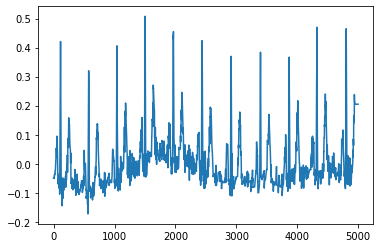

In [45]:
plt.plot(normal_lead2[0])

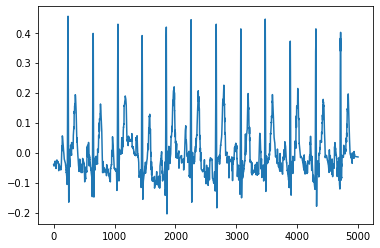

In [65]:
plt.plot(mi_lead2[0])

In [46]:
x_input = []
y_input = []
for i in range(500):
    x_input.append(normal_lead2[i])
    y_input.append(0)
    
    x_input.append(mi_lead2[i])
    y_input.append(1)

In [48]:
x_input = np.array(x_input)
y_input = np.array(y_input)

In [50]:
model = Resnet50((5000, 1))

In [52]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5000, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 5000, 32)     64          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 5000, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 5000, 32)     0           ['batch_normalization[0][0

 ormalization)                                                                                    
                                                                                                  
 re_lu_7 (ReLU)                 (None, 2500, 64)     0           ['batch_normalization_13[0][0]'] 
                                                                                                  
 conv1d_9 (Conv1D)              (None, 2500, 64)     4160        ['re_lu_7[0][0]']                
                                                                                                  
 batch_normalization_14 (BatchN  (None, 2500, 64)    256         ['conv1d_9[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_15 (BatchN  (None, 2500, 64)    256         ['batch_normalization_14[0][0]'] 
 ormalizat

                                                                  're_lu_12[0][0]']               
                                                                                                  
 re_lu_15 (ReLU)                (None, 2500, 512)    0           ['add_4[0][0]']                  
                                                                                                  
 conv1d_18 (Conv1D)             (None, 2500, 128)    65664       ['re_lu_15[0][0]']               
                                                                                                  
 batch_normalization_28 (BatchN  (None, 2500, 128)   512         ['conv1d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_29 (BatchN  (None, 2500, 128)   512         ['batch_normalization_28[0][0]'] 
 ormalizat

                                                                                                  
 conv1d_26 (Conv1D)             (None, 2500, 1024)   263168      ['re_lu_23[0][0]']               
                                                                                                  
 batch_normalization_42 (BatchN  (None, 2500, 1024)  4096        ['conv1d_26[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_43 (BatchN  (None, 2500, 1024)  4096        ['batch_normalization_42[0][0]'] 
 ormalization)                                                                                    
                                                                                                  
 add_7 (Add)                    (None, 2500, 1024)   0           ['batch_normalization_42[0][0]', 
          

                                                                                                  
 conv1d_35 (Conv1D)             (None, 2500, 256)    65792       ['re_lu_31[0][0]']               
                                                                                                  
 batch_normalization_56 (BatchN  (None, 2500, 256)   1024        ['conv1d_35[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_57 (BatchN  (None, 2500, 256)   1024        ['batch_normalization_56[0][0]'] 
 ormalization)                                                                                    
                                                                                                  
 re_lu_32 (ReLU)                (None, 2500, 256)    0           ['batch_normalization_57[0][0]'] 
          

 batch_normalization_69 (BatchN  (None, 2500, 512)   2048        ['conv1d_43[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_70 (BatchN  (None, 2500, 512)   2048        ['batch_normalization_69[0][0]'] 
 ormalization)                                                                                    
                                                                                                  
 re_lu_40 (ReLU)                (None, 2500, 512)    0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 conv1d_44 (Conv1D)             (None, 2500, 512)    262656      ['re_lu_40[0][0]']               
                                                                                                  
 batch_nor

 batch_normalization_84 (BatchN  (None, 2500, 2048)  8192        ['conv1d_52[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_15 (Add)                   (None, 2500, 2048)   0           ['batch_normalization_84[0][0]', 
                                                                  're_lu_45[0][0]']               
                                                                                                  
 re_lu_48 (ReLU)                (None, 2500, 2048)   0           ['add_15[0][0]']                 
                                                                                                  
 average_pooling1d (AveragePool  (None, 1250, 2048)  0           ['re_lu_48[0][0]']               
 ing1D)                                                                                           
          

In [54]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                        optimizer='adam',
                        metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy',
                                                                 dtype=None),
                                 tf.keras.metrics.Recall(name='Recall'),
                                 tf.keras.metrics.Precision(name='Precision'),
                                 tf.keras.metrics.AUC(num_thresholds=200,
                           
                                                      curve="ROC",
                                                      summation_method="interpolation",
                                                      name="AUC",dtype=None,
                                                      thresholds=None,
                                                      multi_label=True,
                                                      label_weights=None,)])

In [58]:
# Split data into train and test
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(x_input, y_input, test_size=0.2, random_state=42)
# Split data into train and test
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [62]:
batchsize = 15

In [66]:
model.fit(x = X_train, y= y_train, validation_data=(X_val, y_val), 
                   epochs=50, 
                   steps_per_epoch=(len(X_train)/(batchsize)), 
                   callbacks= [tf.keras.callbacks.ModelCheckpoint(filepath='Resnet50_base_BinaryCrossentropy_1000sig_with_df_help.hdf5',
                                                      monitor="val_loss",
                                                      verbose=0,
                                                      save_best_only=True,
                                                      save_weights_only=False,
                                                      mode="min",
                                                      save_freq="epoch",
                                                      options=None)])